In [1]:
import numpy as np

from qiskit import Aer

from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import NFT

from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.translators import from_docplex_mp

from qrao.encoding import QuantumRandomAccessEncoding
from qrao.quantum_random_access_optimizer import QuantumRandomAccessOptimizer
from qrao.magic_rounding import MagicRounding

import sys

sys.path.append("/work/gs54/s54005/qrao_experiment/qulacs")

from maxcut_instance_generator import _generate_model_from_graph
from networkx import node_link_graph

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(project="reservations")
kawasaki = provider.get_backend("ibm_kawasaki")
kolkata = provider.get_backend("ibmq_kolkata")

In [28]:
import pickle

with open(
    "/work/gs54/s54005/qrao_experiment/results2/regular/deg3/nodes40/trial0/graph_data.pkl",
    "rb",
) as f:
    data = pickle.load(f)
graph = node_link_graph(data)
num_nodes = graph.number_of_nodes()
edge_weights = np.zeros((num_nodes, num_nodes))
for i, j in graph.edges():
    weight = 1
    edge_weights[i, j] = edge_weights[j, i] = weight
model = _generate_model_from_graph(graph, edge_weights, num_nodes)
problem = from_docplex_mp(model)

encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

print(encoding.num_qubits)

14


In [29]:
from qiskit_nature.runtime import VQEClient

rounding_qi = QuantumInstance(backend=kawasaki, shots=1000)

sweeps = 10
level = 2
entanglement = set()
_, _, weight = encoding._generate_ising_terms(problem)
for i in range(encoding.num_qubits):
    for j in range(i + 1, encoding.num_qubits):
        for v_i in encoding.q2vars[i]:
            for v_j in encoding.q2vars[j]:
                if weight[v_i][v_j] != 0:
                    entanglement.add((i, j))
runtime_vqe = VQEClient(
    ansatz=EfficientSU2(
        encoding.num_qubits,
        reps=level,
        # entanglement=[[i, j] for (i, j) in list(entanglement)],
        entanglement="linear",
        insert_barriers=True,
    ),
    optimizer=NFT(maxfev=(sweeps + 1) * encoding.num_qubits * 2 * 2 * (level + 1)),
    provider=provider,
    backend=kawasaki,
    shots=1024,
    measurement_error_mitigation=False,
    store_intermediate=True,
)

In [30]:
rounding_scheme = MagicRounding(rounding_qi)
qrao = QuantumRandomAccessOptimizer(
    encoding=encoding,
    min_eigen_solver=runtime_vqe,
    rounding_scheme=rounding_scheme,
)

result = qrao.solve()

AttributeError: 'str' object has no attribute 'get'

In [11]:
job_kolkata = provider.runtime.job("ce45vkg6m9bk612aga70")
job_mumbai = provider.runtime.job("ce46anc866kn4u7salj0")

In [27]:
print(len(job_kolkata.result()["optimizer_history"]["params"][0]))

36


In [20]:
history_kolkata = job_kolkata.result()["optimizer_history"]["energy"]
history_mumbai = job_mumbai.result()["optimizer_history"]["energy"]

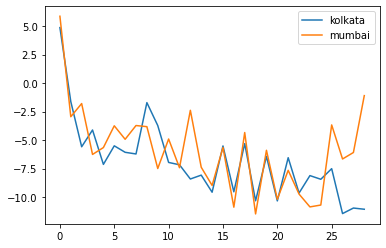

In [30]:
import matplotlib.pyplot as plt

param_len = len(job_kolkata.result()["optimizer_history"]["params"][0])
plt.plot(history_kolkata[::param_len] + encoding.offset, label="kolkata")
plt.plot(history_mumbai[::param_len] + encoding.offset, label="mumbai")
plt.legend()
plt.show()

In [ ]:
from qutip import qeye, sigmax, sigmay, sigmaz, tensor, basis, Qobj
import numpy as np

In [ ]:
state_00 = 0.5 * (qeye(2) + 1/np.sqrt(3) * (sigmax() + sigmay() + sigmaz()))
state_01 = 0.5 * (qeye(2) + 1/np.sqrt(3) * (sigmax() - sigmay() - sigmaz()))
state_10 = 0.5 * (qeye(2) + 1/np.sqrt(3) * (-sigmax() + sigmay() - sigmaz()))
state_11 = 0.5 * (qeye(2) + 1/np.sqrt(3) * (-sigmax() - sigmay() + sigmaz()))

In [37]:
#state = qeye(2)
#state = sigmax()
#state = sigmay()
state = sigmaz()

In [38]:
print(
    0.25 * (
        mu_1_p * state * mu_1_p + mu_1_m * state * mu_1_m +
        mu_2_p * state * mu_2_p + mu_2_m * state * mu_2_m +
        mu_3_p * state * mu_3_p + mu_3_m * state * mu_3_m +
        mu_4_p * state * mu_4_p + mu_4_m * state * mu_4_m
    ),
    0.25 * (
        mu_1_p * state * mu_1_p + mu_1_m2 * state * mu_1_m2 +
        mu_2_p * state * mu_2_p + mu_2_m2 * state * mu_2_m2 +
        mu_3_p * state * mu_3_p + mu_3_m2 * state * mu_3_m2 +
        mu_4_p * state * mu_4_p + mu_4_m2 * state * mu_4_m2
    ),
    state
)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.33333333  0.        ]
 [ 0.         -0.33333333]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.33333333  0.        ]
 [ 0.         -0.33333333]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]


## (3,2)-QRAC の encryption
$b_1\oplus b_2\oplus b_3=0$ の時、
$$\rho_{b_1,b_2,b_3}=\frac{1}{4}II+\frac{1}{4}\left((-1)^{b_1}ZI+(-1)^{b_2}IZ+(-1)^{b_3}ZZ\right)$$
$b_1\oplus b_2\oplus b_3=1$ の時、
$$\rho_{b_1,b_2,b_3}=\frac{1}{4}II+(-1)^{b_1}\left(\frac{1}{12}ZI+\frac{1}{6}XX+\frac{1}{6}XZ\right)$$
$$+(-1)^{b_2}\left(\frac{1}{6}IX+\frac{1}{12}IZ+\frac{1}{6}YY\right)+(-1)^{b_3}\left(\frac{1}{12}ZZ-\frac{1}{6}XI-\frac{1}{6}ZX\right)$$

In [2]:
# (3, 2)-QRAC encryption.
def encode(b_1, b_2, b_3):
    # b_1, b_2, b_3 is 0 or 1
    if (b_1 + b_2 + b_3) % 2 == 0:
        rho = 1 / 4 * tensor(qeye(2), qeye(2)) + 1 / 4 * (
            (-1) ** b_1 * tensor(sigmaz(), qeye(2))
            + (-1) ** b_2 * tensor(qeye(2), sigmaz())
            + (-1) ** b_3 * tensor(sigmaz(), sigmaz())
        )
    else:
        rho = (
            1 / 4 * tensor(qeye(2), qeye(2))
            + (-1) ** b_1
            * (
                1 / 12 * tensor(sigmaz(), qeye(2))
                + 1 / 6 * tensor(sigmax(), sigmax())
                + 1 / 6 * tensor(sigmax(), sigmaz())
            )
            + (-1) ** b_2
            * (
                1 / 6 * tensor(qeye(2), sigmax())
                + 1 / 12 * tensor(qeye(2), sigmaz())
                + 1 / 6 * tensor(sigmay(), sigmay())
            )
            + (-1) ** b_3
            * (
                1 / 12 * tensor(sigmaz(), sigmaz())
                - 1 / 6 * tensor(sigmax(), qeye(2))
                - 1 / 6 * tensor(sigmaz(), sigmax())
            )
        )
    return rho

In [3]:
def observable(idx):
    # 1 -> b_1, 2 -> b_2, 3 -> b_3
    if idx == 1:
        E = 1 / 2 * tensor(qeye(2), qeye(2)) + 1 / np.sqrt(6) * (
            1 / 2 * tensor(sigmax(), sigmax())
            + 1 / 2 * tensor(sigmax(), sigmaz())
            + tensor(sigmaz(), qeye(2))
        )
    elif idx == 2:
        E = 1 / 2 * tensor(qeye(2), qeye(2)) + 1 / np.sqrt(6) * (
            1 / 2 * tensor(sigmay(), sigmay())
            + 1 / 2 * tensor(qeye(2), sigmax())
            + tensor(qeye(2), sigmaz())
        )
    elif idx == 3:
        E = 1 / 2 * tensor(qeye(2), qeye(2)) + 1 / np.sqrt(6) * (
            tensor(sigmaz(), sigmaz())
            - 1 / 2 * tensor(sigmax(), qeye(2))
            - 1 / 2 * tensor(sigmaz(), sigmax())
        )
    else:
        raise ValueError
    return E

In [4]:
# prepare all encoded state
rho_000 = encode(0, 0, 0)
rho_001 = encode(0, 0, 1)
rho_010 = encode(0, 1, 0)
rho_011 = encode(0, 1, 1)
rho_100 = encode(1, 0, 0)
rho_101 = encode(1, 0, 1)
rho_110 = encode(1, 1, 0)
rho_111 = encode(1, 1, 1)

# prepare all observable
E_1 = observable(1)
E_2 = observable(2)
E_3 = observable(3)

In [5]:
# verify magic rounding.
# check b_1
print((E_1 * rho_000).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_1 * rho_001).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_1 * rho_010).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_1 * rho_011).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_1 * rho_100).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_1 * rho_101).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_1 * rho_110).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_1 * rho_111).tr(), 1 / 2 - 1 / np.sqrt(6))

# check b_2
print((E_2 * rho_000).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_2 * rho_001).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_2 * rho_010).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_2 * rho_011).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_2 * rho_100).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_2 * rho_101).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_2 * rho_110).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_2 * rho_111).tr(), 1 / 2 - 1 / np.sqrt(6))

# check b_3
print((E_3 * rho_000).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_3 * rho_001).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_3 * rho_010).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_3 * rho_011).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_3 * rho_100).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_3 * rho_101).tr(), 1 / 2 - 1 / np.sqrt(6))
print((E_3 * rho_110).tr(), 1 / 2 + 1 / np.sqrt(6))
print((E_3 * rho_111).tr(), 1 / 2 - 1 / np.sqrt(6))

0.9082482904638631 0.9082482904638631
0.908248290463863 0.9082482904638631
0.908248290463863 0.9082482904638631
0.9082482904638631 0.9082482904638631
0.09175170953613694 0.09175170953613693
0.09175170953613693 0.09175170953613693
0.09175170953613693 0.09175170953613693
0.09175170953613694 0.09175170953613693
0.9082482904638631 0.9082482904638631
0.908248290463863 0.9082482904638631
0.09175170953613694 0.09175170953613693
0.09175170953613693 0.09175170953613693
0.908248290463863 0.9082482904638631
0.9082482904638631 0.9082482904638631
0.09175170953613693 0.09175170953613693
0.09175170953613694 0.09175170953613693
0.9082482904638631 0.9082482904638631
0.09175170953613694 0.09175170953613693
0.908248290463863 0.9082482904638631
0.09175170953613693 0.09175170953613693
0.908248290463863 0.9082482904638631
0.09175170953613693 0.09175170953613693
0.9082482904638631 0.9082482904638631
0.09175170953613696 0.09175170953613693


In [6]:
ket_0, ket_1 = basis(2, 0), basis(2, 1)
state_000 = tensor(ket_0, ket_0)
state_001 = (
    1
    / np.sqrt(3)
    * (tensor(ket_0, ket_0) + tensor(ket_0, ket_1) + tensor(ket_1, ket_0))
)
state_010 = (
    1
    / np.sqrt(3)
    * (tensor(ket_0, ket_0) - tensor(ket_0, ket_1) + tensor(ket_1, ket_1))
)
state_011 = tensor(ket_0, ket_1)
state_100 = (
    1
    / np.sqrt(3)
    * (-tensor(ket_0, ket_0) + tensor(ket_1, ket_0) + tensor(ket_1, ket_1))
)
state_101 = tensor(ket_1, ket_0)
state_110 = tensor(ket_1, ket_1)
state_111 = (
    1
    / np.sqrt(3)
    * (tensor(ket_0, ket_1) - tensor(ket_1, ket_0) + tensor(ket_1, ket_1))
)

# verify state representation.
# print(rho_000, state_000 * state_000.dag())
# print(rho_001, state_001 * state_001.dag())
# print(rho_010, state_010 * state_010.dag())
# print(rho_011, state_011 * state_011.dag())
# print(rho_100, state_100 * state_100.dag())
# print(rho_101, state_101 * state_101.dag())
# print(rho_110, state_110 * state_110.dag())
# print(rho_111, state_111 * state_111.dag())

In [7]:
def magic_basis(parity):
    if parity == 0:
        magic_basis = (
            basis(4, 0) * state_000.dag()
            + basis(4, 1) * state_011.dag()
            + basis(4, 2) * state_101.dag()
            + basis(4, 3) * state_110.dag()
        )
    elif parity == 1:
        magic_basis = (
            basis(4, 0) * state_001.dag()
            + basis(4, 1) * state_010.dag()
            + basis(4, 2) * state_100.dag()
            + basis(4, 3) * state_111.dag()
        )
    else:
        raise ValueError
    return magic_basis

In [8]:
I_dash = tensor(qeye(2), qeye(2))
X_dash = (
    1 / 2 * tensor(sigmax(), sigmax())
    + 1 / 2 * tensor(sigmax(), sigmaz())
    + tensor(sigmaz(), qeye(2))
)
Y_dash = (
    1 / 2 * tensor(qeye(2), sigmax())
    + tensor(qeye(2), sigmaz())
    + 1 / 2 * tensor(sigmay(), sigmay())
)
Z_dash = (
    tensor(sigmaz(), sigmaz())
    - 1 / 2 * tensor(sigmax(), qeye(2))
    - 1 / 2 * tensor(sigmaz(), sigmax())
)
print(I_dash.tr())
print(X_dash.tr())
print(Y_dash.tr())
print(Z_dash.tr())
print((X_dash * Y_dash).tr())
print((Y_dash * Z_dash).tr())
print((Z_dash * X_dash).tr())
print((X_dash * Z_dash).tr())
print((Z_dash * Y_dash).tr())
print((Y_dash * X_dash).tr())
print((X_dash * X_dash).tr())
print((Y_dash * Y_dash).tr())
print((Z_dash * Z_dash).tr())

4.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.0
6.0
6.0


In [9]:
print(X_dash * Y_dash)
print(I_dash * Z_dash)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.75  0.75  0.75 -0.75]
 [ 0.75 -0.75  0.75  0.75]
 [ 0.75 -0.75 -0.75 -0.75]
 [ 0.75  0.75 -0.75  0.75]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  -0.5 -0.5  0. ]
 [-0.5 -1.   0.  -0.5]
 [-0.5  0.  -1.   0.5]
 [ 0.  -0.5  0.5  1. ]]


In [10]:
def state_constrained(r_x, r_y, r_z):
    rho = 1 / 4 * I_dash + 1 / (2 * np.sqrt(2)) * (
        r_x * X_dash + r_y * Y_dash + r_z * Z_dash
    )
    return rho

In [11]:
example_1 = state_constrained(1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3))
example_2 = state_constrained(1 / np.sqrt(3), -1 / np.sqrt(3), -1 / np.sqrt(3))
example_3 = state_constrained(1 / np.sqrt(2), 0, -1 / np.sqrt(2))
print(example_1.tr(), (example_1 * example_1).tr())
print(example_2.tr(), (example_2 * example_2).tr())
print(example_3.tr(), (example_3 * example_3).tr())

1.0 1.0
1.0 1.0
1.0 0.9999999999999998


In [12]:
def magic_channel(state):
    output = None
    for parity in [0, 1]:
        for b_1 in [0, 1]:
            for b_2 in [0, 1]:
                for b_3 in [0, 1]:
                    if (b_1 + b_2 + b_3) % 2 == parity:
                        basis = encode(b_1, b_2, b_3)
                        if output is None:
                            output = (basis * state).tr() * basis
                        else:
                            output += (basis * state).tr() * basis
#     for parity in [0, 1]:
#         tmp = (magic_basis(parity) * state).tr() * magic_basis(parity)
#         if output is None:
#             output = tmp
#         else:
#             output += tmp
    return output / 2

In [13]:
print(magic_channel(I_dash), I_dash)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [14]:
print(magic_channel(X_dash), X_dash)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.66666667  0.          0.33333333  0.33333333]
 [ 0.          0.66666667  0.33333333 -0.33333333]
 [ 0.33333333  0.33333333 -0.66666667  0.        ]
 [ 0.33333333 -0.33333333  0.         -0.66666667]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.   0.   0.5  0.5]
 [ 0.   1.   0.5 -0.5]
 [ 0.5  0.5 -1.   0. ]
 [ 0.5 -0.5  0.  -1. ]]


In [15]:
print(magic_channel(Y_dash), Y_dash)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.66666667  0.33333333  0.         -0.33333333]
 [ 0.33333333 -0.66666667  0.33333333  0.        ]
 [ 0.          0.33333333  0.66666667  0.33333333]
 [-0.33333333  0.          0.33333333 -0.66666667]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.   0.5  0.  -0.5]
 [ 0.5 -1.   0.5  0. ]
 [ 0.   0.5  1.   0.5]
 [-0.5  0.   0.5 -1. ]]


In [16]:
print(magic_channel(Z_dash), Z_dash)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.66666667 -0.33333333 -0.33333333  0.        ]
 [-0.33333333 -0.66666667  0.         -0.33333333]
 [-0.33333333  0.         -0.66666667  0.33333333]
 [ 0.         -0.33333333  0.33333333  0.66666667]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  -0.5 -0.5  0. ]
 [-0.5 -1.   0.  -0.5]
 [-0.5  0.  -1.   0.5]
 [ 0.  -0.5  0.5  1. ]]


In [17]:
# IY
print(np.array_equal(magic_channel(tensor(qeye(2), sigmay())).full(), np.zeros((4, 4))))

# YI
print(np.array_equal(magic_channel(tensor(sigmay(), qeye(2))).full(), np.zeros((4, 4))))

# XY
print(np.array_equal(magic_channel(tensor(sigmax(), sigmay())).full(), np.zeros((4, 4))))

# YX
print(np.array_equal(magic_channel(tensor(sigmay(), sigmax())).full(), np.zeros((4, 4))))

# YZ
print(np.array_equal(magic_channel(tensor(sigmay(), sigmaz())).full(), np.zeros((4, 4))))

# ZY
print(np.array_equal(magic_channel(tensor(sigmaz(), sigmay())).full(), np.zeros((4, 4))))

True
True
True
True
True
True


In [18]:
# XX 
print(np.array_equal(magic_channel(tensor(sigmax(), sigmax())).full(), tensor(sigmax(), sigmax())))

# XZ
print(np.array_equal(magic_channel(tensor(sigmax(), sigmaz())).full(), tensor(sigmax(), sigmaz())))

# ZI
print(np.array_equal(magic_channel(tensor(sigmaz(), qeye(2))).full(), tensor(sigmaz(), qeye(2))))

# IX
print(np.array_equal(magic_channel(tensor(qeye(2), sigmax())).full(), tensor(qeye(2), sigmax())))

# IZ
print(np.array_equal(magic_channel(tensor(qeye(2), sigmaz())).full(), tensor(qeye(2), sigmaz())))

# YY
print(np.array_equal(magic_channel(tensor(sigmay(), sigmay())).full(), tensor(sigmay(), sigmay())))

# ZZ
print(np.array_equal(magic_channel(tensor(sigmaz(), sigmaz())).full(), tensor(sigmaz(), sigmaz())))

# XI
print(np.array_equal(magic_channel(tensor(sigmax(), qeye(2))).full(), tensor(sigmax(), qeye(2))))

# ZX
print(np.array_equal(magic_channel(tensor(sigmaz(), sigmax())).full(), tensor(sigmaz(), sigmax())))

False
False
False
False
False
False
False
False
False


In [19]:
magic_basis(1)

Quantum object: dims = [[4], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.57735027  0.57735027  0.57735027  0.        ]
 [ 0.57735027 -0.57735027  0.          0.57735027]
 [-0.57735027  0.          0.57735027  0.57735027]
 [ 0.          0.57735027 -0.57735027  0.57735027]]

In [20]:
magic_basis(1) * magic_basis(1).dag()

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [21]:
magic_basis(0) * magic_basis(0).dag()

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [23]:
bases = [0.5 * (qeye(2) + (1/np.sqrt(2)) * (sigmax() + sigmay())),
0.5 * (qeye(2) - (1/np.sqrt(2)) * (sigmax() + sigmay())),
0.5 * (qeye(2) + (1/np.sqrt(2)) * (sigmax() - sigmay())),
0.5 * (qeye(2) - (1/np.sqrt(2)) * (sigmax() - sigmay())),
0.5 * (qeye(2) + (1/np.sqrt(2)) * (sigmay() + sigmaz())),
0.5 * (qeye(2) - (1/np.sqrt(2)) * (sigmay() + sigmaz())),
0.5 * (qeye(2) + (1/np.sqrt(2)) * (sigmay() - sigmaz())),
0.5 * (qeye(2) - (1/np.sqrt(2)) * (sigmay() - sigmaz())),
0.5 * (qeye(2) + (1/np.sqrt(2)) * (sigmaz() + sigmax())),
0.5 * (qeye(2) - (1/np.sqrt(2)) * (sigmaz() + sigmax())),
0.5 * (qeye(2) + (1/np.sqrt(2)) * (sigmaz() - sigmax())),
0.5 * (qeye(2) - (1/np.sqrt(2)) * (sigmaz() - sigmax()))]

In [29]:
def magic_channel_x(state):
    output = None
    for i in range(12):
        if output is None:
            output = (bases[i] * state).tr() * bases[i]
        else:
            output += (bases[i] * state).tr() * bases[i]
    return output / 6

In [30]:
print(magic_channel_x(qeye(2)), qeye(2))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


In [31]:
print(magic_channel_x(sigmax()), sigmax())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         0.33333333]
 [0.33333333 0.        ]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]


In [32]:
print(magic_channel_x(sigmay()), sigmay())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.33333333j]
 [0.+0.33333333j 0.+0.j        ]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]


In [33]:
print(magic_channel_x(sigmaz()), sigmaz())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.33333333  0.        ]
 [ 0.         -0.33333333]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]


In [ ]:
def encode52(b_1,b_2,b_3,b_4,b_5):
    return 0.25 * (tensor(qeye(2), qeye(2)) + 1 * (
        (-1)**b_1 * tensor() + (-1)**b_2 * tensor() + (-1)**b_3 * tensor() + (-1)**b_4 * tensor() + (-1)**b_5 * tensor()
    ))

In [34]:
state = 0.25 * tensor(qeye(2), qeye(2)) + 0.25 * (
    tensor(sigmaz(), qeye(2)) + tensor(qeye(2),sigmaz()) + tensor(sigmaz(), sigmaz())
)

TypeError: Incompatible quantum object dimensions

In [1]:
from math import factorial
import matplitlib.pyplot as plt

def prob(k,n,d):
    total = int(k * (n-k) * d / (n-1))
    x = [i for i in range(1, total)]
    y = [factorial(total)/(2**total)*factorial(total-i)*factorial(i) for i in range(1, total)]
    plt.show(x,y)

ImportError: cannot import name 'combination' from 'collections' (/work/gs54/s54005/.pyenv/versions/3.8.14/lib/python3.8/collections/__init__.py)

In [ ]:
prob(15, 40, 3)

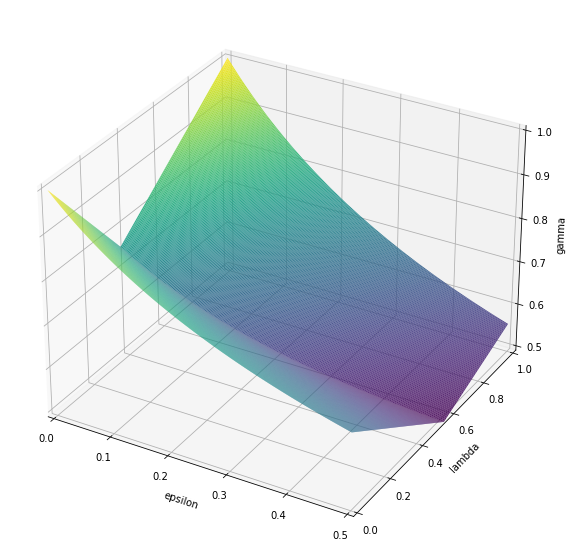

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.linspace(0,0.5,300)
y = np.linspace(0,1,300)
X, Y = np.meshgrid(x, y)
Z = np.amax(np.array([(3-2*Y+2*X) / (3+6*X), (9-2*np.sqrt(3)+2*np.sqrt(3)*Y+2*X) / (9+18*X)]), axis=0)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set(xlim=(0, 0.5), ylim=(0, 1), zlim=(0, 1),
       xlabel='epsilon', ylabel='lambda', zlabel='gamma')

plt.show()

In [10]:
import numpy as np
num_nodes = [30, 32, 34, 36, 38, 40, 42, 44, 46, 48]
base_path = '/work/gs54/s54005/qrao_experiment/results4_data/weighted/deg3/'
compatible_relax_dict = {}
linear_relax_dict = {}
random_relax_dict = {}
compatible_magic_dict = {}
linear_magic_dict = {}
random_magic_dict = {}
compatible_pauli_dict = {}
linear_pauli_dict = {}
random_pauli_dict = {}
for num_node in num_nodes:
    nodes_path = base_path + f'nodes{num_node}/'
    data = np.load(nodes_path + 'data.npz', allow_pickle=True)
    compatible_relax_dict[num_node] = data['compatible_relax']
    linear_relax_dict[num_node] = data['linear_relax']
    random_relax_dict[num_node] = data['random_relax']
    compatible_magic_dict[num_node] = data['compatible_magic']
    linear_magic_dict[num_node] = data['linear_magic']
    random_magic_dict[num_node] = data['random_magic']
    compatible_pauli_dict[num_node] = data['compatible_pauli']
    linear_pauli_dict[num_node] = data['linear_pauli']
    random_pauli_dict[num_node] = data['random_pauli']

In [8]:
def fetch_depth(array, depth):
    np_array = np.array(array).T
    target_array = np_array[depth]
    return target_array.T 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_rounding_result(scale=10, xmin=29, xmax=49, ymin=0.3, ymax=1.05, depth=0, entanglement="compatible"):

    fig, ax1 = plt.subplots(figsize=(9,6))
    bins = np.linspace(ymin, ymax, 40)
    if entanglement == "compatible":
        magic_dict = compatible_magic_dict
        pauli_dict = compatible_pauli_dict
    elif entanglement == "linear":
        magic_dict = linear_magic_dict
        pauli_dict = linear_pauli_dict
    elif entanglement == "random":
        magic_dict = random_magic_dict
        pauli_dict = random_pauli_dict
    else:
        raise ValueError
    
    for num_node in num_nodes:
        ax1.hist(
            fetch_depth(magic_dict[num_node], depth),
            bins=bins,
            align='left',
            orientation="horizontal",
            bottom=num_node*scale,
            rwidth=0.8,
            color="blue",
            label="Magic State Rounding" if num_node == 30 else None,
        )
    ax1.set_xlim(xmin*scale, xmax*scale)
    ax1.set_xticks(
        [num_node*scale for num_node in num_nodes],
        [f'{num_node}' for num_node in num_nodes]
    )
    ax1.plot([xmin*scale, xmax*scale], [1, 1], color="black")
    # ax1.plot([xmin*scale, xmax*scale], [5/9, 5/9], color="red")
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel("Approximation Ratio")
    ax1.set_xlabel("Number of Nodes")
    ax2 = ax1.twiny()
    ax2.axis("off")
    for num_node, bottom in zip(num_nodes, reversed(num_nodes)):
        ax2.hist(
            fetch_depth(pauli_dict[num_node], depth),
            bins=bins,
            align='left',
            orientation="horizontal",
            bottom=bottom*scale,
            rwidth=0.8,
            color="green",
            label="Pauli Rounding" if num_node == 30 else None,
        )
    ax2.set_xlim(xmax*scale, xmin*scale)
    fig.legend(bbox_to_anchor=(0.9, 0.14), loc="lower right")
    fig.show()

In [4]:
from matplotlib.patches import Patch

def plot_relaxed_result(scale=10, xmin=29, xmax=49, ymin=0.8, ymax=1.6, depth=0, entanglement="compatible"):

    fig, ax1 = plt.subplots(figsize=(9,6))
    bins = np.linspace(ymin, ymax, 40)
    
    if entanglement == "compatible":
        relax_dict = compatible_relax_dict
    elif entanglement == "linear":
        relax_dict = linear_relax_dict
    elif entanglement == "random":
        relax_dict = random_relax_dict

    for num_node in num_nodes:
        ax1.hist(
            fetch_depth(relax_dict[num_node], depth),
            bins=bins,
            align='left',
            orientation="horizontal",
            bottom=num_node*scale,
            rwidth=0.8,
            color="green",
            stacked=False,
            label=entanglement if num_nodes == 30 else None,
        )
    ax1.set_xlim(xmin*scale, xmax*scale)
    ax1.set_xticks(
        [num_node*scale for num_node in num_nodes],
        [f'{num_node}' for num_node in num_nodes]
    )
    ax1.plot([xmin*scale, xmax*scale], [1, 1], color="red")
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel("Relax State Energy / Optimum Value")
    ax1.set_xlabel("Number of Nodes")
    # fig.legend(bbox_to_anchor=(0.9, 0.14), loc="lower right")
    fig.show()

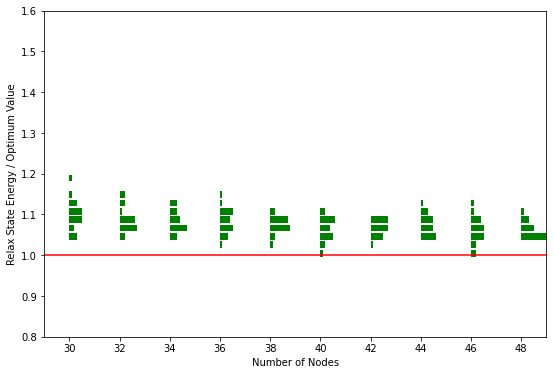

In [5]:
plot_relaxed_result(depth=2, entanglement="random")

In [6]:
def plot_rounding_results_with_error_bar(
    num_nodes: int,
    num_levels: int = 3,
    save_file_name: str = None,
):
    compatible_magic_results = compatible_magic_dict[num_nodes]
    linear_magic_results = linear_magic_dict[num_nodes]
    random_magic_results = random_magic_dict[num_nodes]
    compatible_pauli_results = compatible_pauli_dict[num_nodes]
    linear_pauli_results = linear_pauli_dict[num_nodes]
    random_pauli_results = random_pauli_dict[num_nodes]
    compatible_magic_err = [
        compatible_magic_results.mean(axis=0) - compatible_magic_results.min(axis=0),
        compatible_magic_results.max(axis=0) - compatible_magic_results.mean(axis=0),
    ]
    linear_magic_err = [
        linear_magic_results.mean(axis=0) - linear_magic_results.min(axis=0),
        linear_magic_results.max(axis=0) - linear_magic_results.mean(axis=0),
    ]
    random_magic_err = [
        random_magic_results.mean(axis=0) - random_magic_results.min(axis=0),
        random_magic_results.max(axis=0) - random_magic_results.mean(axis=0),
    ]
    compatible_pauli_err = [
        compatible_pauli_results.mean(axis=0) - compatible_pauli_results.min(axis=0),
        compatible_pauli_results.max(axis=0) - compatible_pauli_results.mean(axis=0),
    ]
    linear_pauli_err = [
        linear_pauli_results.mean(axis=0) - linear_pauli_results.min(axis=0),
        linear_pauli_results.max(axis=0) - linear_pauli_results.mean(axis=0),
    ]
    random_pauli_err = [
        random_pauli_results.mean(axis=0) - random_pauli_results.min(axis=0),
        random_pauli_results.max(axis=0) - random_pauli_results.mean(axis=0),
    ]

    plt.plot(
        [-0.3, num_levels - 0.7],
        [1, 1],
        color="black",
        label="opt",
        linestyle="-",
        linewidth=0.5,
    )
    plt.plot(
        [-0.3, num_levels - 0.7],
        [5 / 9, 5 / 9],
        color="purple",
        label="lower bound",
        linestyle="-",
        linewidth=0.5,
    )
    plt.errorbar(
        [i - 0.125 for i in range(num_levels)],
        compatible_magic_results.mean(axis=0),
        compatible_magic_err,
        marker="o",
        markerfacecolor="white",
        markeredgecolor="blue",
        markersize=8,
        linestyle="dashed",
        color="blue",
        label="compatible (magic)",
        capsize=8,
    )
    plt.errorbar(
        [i - 0.025 for i in range(num_levels)],
        linear_magic_results.mean(axis=0),
        linear_magic_err,
        marker="o",
        markerfacecolor="white",
        markeredgecolor="red",
        markersize=8,
        linestyle="dashed",
        color="red",
        label="linear (magic)",
        capsize=8,
    )
    plt.errorbar(
        [i + 0.075 for i in range(num_levels)],
        random_magic_results.mean(axis=0),
        random_magic_err,
        marker="o",
        markerfacecolor="white",
        markeredgecolor="green",
        markersize=8,
        linestyle="dashed",
        color="green",
        label="random (magic)",
        capsize=8,
    )
    plt.errorbar(
        [i - 0.075 for i in range(num_levels)],
        compatible_pauli_results.mean(axis=0),
        compatible_pauli_err,
        marker="o",
        markerfacecolor="blue",
        markeredgecolor="blue",
        markersize=8,
        linestyle="dotted",
        color="blue",
        label="compatible (pauli)",
        capsize=8,
    )
    plt.errorbar(
        [i + 0.025 for i in range(num_levels)],
        linear_pauli_results.mean(axis=0),
        linear_pauli_err,
        marker="o",
        markerfacecolor="red",
        markeredgecolor="red",
        markersize=8,
        linestyle="dotted",
        color="red",
        label="linear (pauli)",
        capsize=8,
    )
    plt.errorbar(
        [i + 0.125 for i in range(num_levels)],
        random_pauli_results.mean(axis=0),
        random_pauli_err,
        marker="o",
        markerfacecolor="green",
        markeredgecolor="green",
        markersize=8,
        linestyle="dotted",
        color="green",
        label="random (pauli)",
        capsize=8,
    )

    plt.xticks([i for i in range(num_levels)])
    plt.xlim(-0.3, num_levels - 0.7)
    plt.ylim(0, 1.05)
    plt.ylabel("Approximation ratio")
    plt.xlabel("Number of entanglement layers")
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    if save_file_name is not None:
        plt.savefig(save_file_name, bbox_inches="tight")
    plt.show()

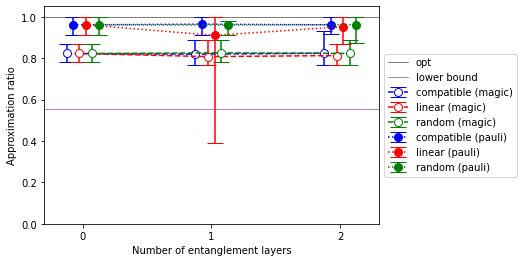

In [7]:
plot_rounding_results_with_error_bar(34)

In [209]:
linear_pauli_dict[34]

array([[0.82352941, 0.94117647, 0.88235294],
       [1.        , 0.76923077, 1.        ],
       [0.82608696, 0.91304348, 1.        ],
       [0.84210526, 0.89473684, 1.        ],
       [0.95238095, 0.9047619 , 0.9047619 ],
       [0.86666667, 0.86666667, 0.93333333],
       [0.94444444, 0.94444444, 0.94444444],
       [0.73684211, 0.94736842, 0.94736842],
       [0.83333333, 1.        , 0.94444444],
       [0.9375    , 0.875     , 0.875     ],
       [0.88235294, 0.94117647, 0.94117647],
       [0.64285714, 0.78571429, 1.        ],
       [0.92307692, 1.        , 0.92307692],
       [0.9047619 , 0.80952381, 0.80952381],
       [0.81481481, 1.        , 0.85185185],
       [0.9047619 , 0.9047619 , 0.95238095],
       [0.875     , 0.125     , 0.83333333],
       [1.        , 0.15      , 0.        ],
       [0.95238095, 0.9047619 , 0.9047619 ],
       [0.92      , 1.        , 1.        ]])

In [14]:
sum_c12 = 0
for num_node in num_nodes:
    c_0 = 0
    c_1 = 0
    c_2 = 0
    c_12 = 0
    c_lt1 = 0
    c_lt2 = 0
    for instance in random_pauli_dict[num_node]:
        if instance[0] == 1:
            c_0 += 1
        if instance[1] == 1:
            c_1 += 1
        if instance[2] == 1:
            c_2 += 1
        if instance[0] != 1 and (instance[1] == 1 or instance[2] == 1):
            c_12 += 1
        if instance[0] == 1 or instance[1] == 1:
            c_lt1 += 1
        if instanc[0] == 1 or instance[1] == 1 or instance[2] == 1:
            c_lt2 += 1
    print(num_node, c_lt1, c_lt2)
    sum_c12 += c_12
print(sum_c12 / len(num_nodes))

30 55 58
32 40 47
34 21 32
36 29 32
38 28 36
40 26 33
42 24 28
44 16 20
46 24 25
48 20 29
17.8
